In [107]:
# import pandas as pd
# import ast
# import numpy as np
# from collections import defaultdict

# label_df = pd.read_csv("./data/scin_labels.csv")

# unique_labels = set()
# for raw in label_df['dermatologist_skin_condition_on_label_name'].dropna():
#     try:
#         lst = ast.literal_eval(raw)
#         if isinstance(lst, list):
#             unique_labels.update(lst)
#     except (ValueError, SyntaxError):
#         continue

# print(f"총 {len(unique_labels)}개의 원본 라벨:")
# for lab in sorted(unique_labels):
#     print(" ", lab)

# unique_labels_sorted = sorted(unique_labels)

In [ ]:
# # scin_group_map.py

# # 1) 메인 그룹 정의
# # - 아토피: Atopic Dermatitis, Eczema 계열
# # - 접촉성 피부염: Contact Dermatitis 계열
# # - 건선: Psoriasis 계열
# # - 태선화: Lichen planus/lichenoid, Lichen Simplex Chronicus 계열
# # - 기타: 나머지 라벨 전부

# # 2) 원본 키워드 기반 자동 매핑
# GROUP_MAP = {}

# # (A) 아토피 계열
# for key in unique_labels_sorted:
#     if any(sub in key for sub in ["Atopic Dermatitis", "Eczema", "dermatitis"]):
#         # “Contact Dermatitis” 제외
#         if "Contact Dermatitis" not in key:
#             GROUP_MAP[key] = "아토피"

# # (B) 접촉성 피부염 계열
# for key in unique_labels_sorted:
#     if "Contact Dermatitis" in key or "Contact dermatitis" in key:
#         GROUP_MAP[key] = "접촉성 피부염"

# # (C) 건선 계열
# for key in unique_labels_sorted:
#     if "Psoriasis" in key or "psoria" in key.lower():
#         GROUP_MAP[key] = "건선"

# # (D) 태선화 계열
# for key in unique_labels_sorted:
#     if "Lichen planus" in key or "Lichen Simplex Chronicus" in key or "lichen" in key.lower():
#         GROUP_MAP[key] = "태선화"

# # (E) 기타: 위 네 그룹에 속하지 않는 라벨
# for key in unique_labels_sorted:
#     if key not in GROUP_MAP:
#         GROUP_MAP[key] = "기타"

# # (F) 정상피부: handled separately when parsed_labels is empty

In [108]:
# from collections import Counter

# group_counts = Counter(GROUP_MAP.values())
# print("그룹별 원본 라벨 개수:", group_counts)

# import pandas as pd

# df_counts = pd.Series(GROUP_MAP).value_counts().rename_axis('Group').reset_index(name='Label Count')
# print(df_counts)

In [109]:
# import pandas as pd
# import ast
# from collections import defaultdict

# # 1) 파일 경로 설정
# INPUT_LABEL_PATH  = "./data/scin_labels.csv"        # 원본 SCIN 라벨 CSV 경로
# INPUT_CASE_PATH   = "./data/scin_cases.csv"         # SCIN 케이스 메타데이터 경로
# OUTPUT_PATH       = "./data/scin_labels_final.csv"  # 멀티클래스 레이블 저장 경로

# # 2) 데이터 로드
# labels_df = pd.read_csv(INPUT_LABEL_PATH)
# cases_df  = pd.read_csv(INPUT_CASE_PATH)[[
#     "case_id",
#     "related_category",
#     "image_1_path",
#     "image_2_path",
#     "image_3_path"
# ]]

# # 3) 원본 레이블 리스트 파싱
# def parse_labels(raw):
#     try:
#         labels = ast.literal_eval(raw)
#         return labels if isinstance(labels, list) else []
#     except:
#         return []

# labels_df["parsed_labels"] = labels_df["dermatologist_skin_condition_on_label_name"].apply(parse_labels)

# # 4) 고유 레이블 추출 및 그룹맵 생성
# unique_labels = set(l for labs in labels_df["parsed_labels"] for l in labs)
# GROUP_MAP = {}
# for lab in sorted(unique_labels):
#     if any(sub in lab for sub in ["Atopic Dermatitis", "Eczema", "dermatitis"]) and "Contact Dermatitis" not in lab:
#         GROUP_MAP[lab] = "아토피"
#     elif "Contact Dermatitis" in lab or "Contact dermatitis" in lab:
#         GROUP_MAP[lab] = "접촉성 피부염"
#     elif "Psoriasis" in lab or "psoria" in lab.lower():
#         GROUP_MAP[lab] = "건선"
#     elif "Lichen planus" in lab or "Lichen Simplex Chronicus" in lab or "lichen" in lab.lower():
#         GROUP_MAP[lab] = "태선화"
#     else:
#         GROUP_MAP[lab] = "기타"

# # 5) 가중 레이블 dict 파싱 및 그룹 점수 합산 함수
# def parse_weighted(raw):
#     try:
#         return ast.literal_eval(raw)
#     except:
#         return {}

# def aggregate_group_scores(label_dict):
#     scores = defaultdict(float)
#     for lab, prob in label_dict.items():
#         grp = GROUP_MAP.get(lab, "기타")
#         scores[grp] += prob
#     return scores

# labels_df["parsed_dict"]  = labels_df["weighted_skin_condition_label"].apply(parse_weighted)
# labels_df["group_scores"] = labels_df["parsed_dict"].apply(aggregate_group_scores)

# # 6) 케이스와 라벨 병합
# merged = labels_df.merge(cases_df, on="case_id", how="left")

# # 7) 최종 레이블 선택 함수: "LOOKS_HEALTHY"만으로 정상피부 판별

# def is_normal(row):
#     return row['related_category'] == 'LOOKS_HEALTHY'

# # 8) 스코어 기반 클래스 결정
# # LOOKS_HEALTHY면 '정상피부', 그렇지 않으면 최대 점수 그룹으로 분류

# def pick_final_label(row):
#     if is_normal(row):
#         return '정상피부'
#     scores = row['group_scores']
#     if not scores:
#         return '기타'
#     grp, _ = max(scores.items(), key=lambda x: x[1])
#     return grp

# merged['final_label'] = merged.apply(pick_final_label, axis=1)

# # 9) 이미지 경로 정리 및 Long format 변환
# df = merged[['case_id', 'image_1_path', 'image_2_path', 'image_3_path', 'final_label']]
# long_df = pd.melt(
#     df,
#     id_vars=['case_id', 'final_label'],
#     value_vars=['image_1_path', 'image_2_path', 'image_3_path'],
#     var_name='image_type',
#     value_name='image_path'
# )
# final_df = long_df.dropna(subset=['image_path']).reset_index(drop=True)
# final_df['image_number'] = final_df.index.map(lambda x: f"{x:05d}.png")
# final_df['image_path'] = final_df['image_path'].apply(lambda x: x.split('/')[-1])

# # 10) 결과 저장
# final_df.to_csv(OUTPUT_PATH, index=False)
# print(f"Saved {len(final_df)} samples with final_label to {OUTPUT_PATH}")

In [110]:
# df['final_label'].value_counts()

## 이미지

In [6]:
# # 백업본
# if os.path.exists('./data/images_backup'):
#     shutil.rmtree('./data/images_backup')
# os.makedirs('./data/images_backup', exist_ok=True)
# for i in os.listdir('./data/images'):
#     src = os.path.join('./data/images', i)
#     dst = os.path.join('./data/images_backup', i)
#     shutil.copy(src, dst)


# for i in os.listdir("./data/images"):
#     os.rename(f"./data/images/{i}", os.path.join("./data/images", final_df[final_df['image_path'] == i]['image_number'].values[0]))

In [111]:
# import os
# import pandas as pd
# import shutil

# final_df = pd.read_csv('./data/scin_labels_final.csv')

# next_number = len(os.listdir("./data/images"))

# # 빈 리스트로 row 누적
# new_rows = []

# # synthesis 데이터 처리
# synthesis_list = os.listdir("./data/synthesis/")
# for i in synthesis_list:
#     syn_dir = os.path.join("./data/synthesis/", i)

#     for j in os.listdir(syn_dir):
#         # 새 행 저장
#         new_rows.append({
#             'image_number': str(next_number).zfill(5) + ".png",
#             'final_label': i.split("_")[-1]
#         })

#         # 이미지 복사
#         src = os.path.join(syn_dir, j)
#         dst = os.path.join("./data/images", str(next_number).zfill(5) + ".png")
#         shutil.copy(src, dst)

#         next_number += 1

# # 누적된 행을 DataFrame으로 변환 후 concat
# new_df = pd.DataFrame(new_rows)
# final_df = pd.concat([final_df, new_df], ignore_index=True)

In [112]:
# import pandas as pd
# import unicodedata

# df = final_df.copy(deep=True)
# df = df.drop(columns=["image_path"])
# df = df.rename(columns={'image_number': 'image_path'})
# df = df[['image_path', 'final_label']]
# df['final_label'] = df['final_label'].apply(lambda x: unicodedata.normalize("NFC", str(x)).strip())
# df['final_label'] = df['final_label'].apply(lambda x: unicodedata.normalize("NFC", str(x)).strip())
# df.rename(columns={"final_label":"label"}, inplace=True)

# df.to_csv("./data/scin_final.csv", index=False)

# print(len(os.listdir("./data/images")))
# print(len(pd.read_csv("./data/scin_final.csv")))

## 정상, 기타 피부 제외 (아토피, 접촉성, 건선, 태선화 만 봄)

In [10]:
# df = pd.read_csv("./data/scin_final.csv")
# df['label'].value_counts()

label
정상피부       4405
기타         3984
아토피        1105
접촉성 피부염     703
건선          231
태선화         220
Name: count, dtype: int64

In [11]:
# import os
# import shutil
# OUTPUT_IMAGE_PATH = './data/disesase_images'

# if os.path.exists(OUTPUT_IMAGE_PATH):
#     shutil.rmtree(OUTPUT_IMAGE_PATH)
# os.makedirs(OUTPUT_IMAGE_PATH, exist_ok=True)

# tgt_label=["아토피", "접촉성 피부염", "건선", "태선화"]

# disease_df = df[df['label'].isin(tgt_label)]

# for i in disease_df['image_path']:
#     try:
#         src = os.path.join('./data/images', i)
#         dst = os.path.join(OUTPUT_IMAGE_PATH, i)
    
#         shutil.copy(src, dst)
#     except FileNotFoundError:
#         print(f"File not found: {src}")
#         disease_df.drop(disease_df[disease_df['image_path'] == i].index, inplace=True)
#         disease_df.to_csv("./data/disease_df.csv", index=False)
#         continue

File not found: ./data/images/04361.png
File not found: ./data/images/04789.png


/var/folders/46/l2s5j4tx3nq6w96k_zcvff9c0000gn/T/ipykernel_36046/1391212330.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disease_df.drop(disease_df[disease_df['image_path'] == i].index, inplace=True)


File not found: ./data/images/07697.png
File not found: ./data/images/07963.png


In [ ]:
# from sklearn.model_selection import train_test_split

# train_df, tmp = train_test_split(disease_df, test_size=0.2, random_state=42, stratify=disease_df['label'])
# valid_df, test_df = train_test_split(tmp, test_size=0.5, random_state=42, stratify=tmp['label'])

# train_df.to_csv("./data/train.csv", index=False)
# valid_df.to_csv("./data/valid.csv", index=False)
# test_df.to_csv("./data/test.csv", index=False)


# dirs = ['train', 'valid', 'test']
# for dir in dirs:
#     src_dir = os.path.join('./data/disesase_images')
#     dst_dir = os.path.join('./data', dir)
#     if os.path.join(dst_dir):
#         shutil.rmtree(dst_dir)
#     os.makedirs(os.path.join(dst_dir), exist_ok=True)

#     if dir == 'train':
#         df = train_df
#     elif dir == 'valid':
#         df = valid_df
#     else:
#         df = test_df

#     for i in df['image_path']:
#         src = os.path.join(src_dir, i)
#         dst = os.path.join(dst_dir, i)

#         try:
#             shutil.copy(src, dst)
#         except FileNotFoundError:
#             print(f"File not found: {src}")
#             df.drop(df[df['image_path'] == i].index, inplace=True)
#             continue


In [13]:
# train_df['label'].value_counts(), valid_df['label'].value_counts(), test_df['label'].value_counts()

(label
 아토피        882
 접촉성 피부염    561
 건선         185
 태선화        176
 Name: count, dtype: int64,
 label
 아토피        110
 접촉성 피부염     70
 건선          23
 태선화         22
 Name: count, dtype: int64,
 label
 아토피        111
 접촉성 피부염     70
 건선          23
 태선화         22
 Name: count, dtype: int64)

In [15]:
# mode = ['train', 'valid','test']
# for m in mode:
#     print(f"{m} image length: ", len(os.listdir(f"./data/{m}")))
#     df = pd.read_csv(f"./data/{m}.csv")
#     print(f"{m} df length: ", len(df))

train image length:  1804
train df length:  1804
valid image length:  225
valid df length:  225
test image length:  226
test df length:  226


# 정상 포함

In [76]:
# import pandas as pd
# import random
# df = pd.read_csv("./data/scin_final.csv")
# random.seed(42)

# case = 'normal'

# import os
# import shutil
# OUTPUT_IMAGE_PATH = f'./data/{case}/normal_images'

# if os.path.exists(OUTPUT_IMAGE_PATH):
#     shutil.rmtree(OUTPUT_IMAGE_PATH)
# os.makedirs(OUTPUT_IMAGE_PATH, exist_ok=True)

# tgt_label=["아토피", "접촉성 피부염", "건선", "태선화"]

# normal_df = df[df['label'].isin(tgt_label)]

# normal_df.to_csv(f"./data/{case}/normal.csv", index=False)
# normal_df['label'].value_counts()


label
아토피        1222
접촉성 피부염     711
정상피부        588
건선          296
태선화         244
Name: count, dtype: int64

In [77]:
# for i in normal_df['image_path']:
#     try:
#         src = os.path.join(f'./data/images', i)
#         dst = os.path.join(OUTPUT_IMAGE_PATH, i)
    
#         shutil.copy(src, dst)
#     except FileNotFoundError:
#         print(f"File not found: {src}")
#         normal_df.drop(normal_df[normal_df['image_path'] == i].index, inplace=True)
#         normal_df.to_csv(f"./data/{case}/normal.csv", index=False) # 이미지가 없는경우 csv도 갱신
#         continue

# from sklearn.model_selection import train_test_split

# train_df, tmp = train_test_split(normal_df, test_size=0.2, random_state=42, stratify=normal_df['label'])
# valid_df, test_df = train_test_split(tmp, test_size=0.5, random_state=42, stratify=tmp['label'])

# train_df.to_csv(f"./data/{case}/train.csv", index=False)
# valid_df.to_csv(f"./data/{case}/valid.csv", index=False)
# test_df.to_csv(f"./data/{case}/test.csv", index=False)


# dirs = ['train', 'valid', 'test']
# for dir in dirs:
#     src_dir = os.path.join(f'./data/images')
#     dst_dir = os.path.join('./data', case, dir)
#     if os.path.exists(os.path.join(dst_dir)):
#         shutil.rmtree(dst_dir)
#     os.makedirs(os.path.join(dst_dir), exist_ok=True)

#     if dir == 'train':
#         df = train_df
#     elif dir == 'valid':
#         df = valid_df
#     else:
#         df = test_df

#     for i in df['image_path']:
#         src = os.path.join(src_dir, i)
#         dst = os.path.join(dst_dir, i)

#         try:
#             shutil.copy(src, dst)
#         except FileNotFoundError:
#             print(f"File not found: {src}")
#             df.drop(df[df['image_path'] == i].index, inplace=True)
#             continue


File not found: ./data/images/04361.png
File not found: ./data/images/04789.png


/var/folders/46/l2s5j4tx3nq6w96k_zcvff9c0000gn/T/ipykernel_36046/1028513625.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_df.drop(normal_df[normal_df['image_path'] == i].index, inplace=True)


File not found: ./data/images/07697.png
File not found: ./data/images/07963.png


In [53]:
# import pandas as pd

# # 1) 레이블 로드
# cases = pd.read_csv("./data/scin_cases.csv")
# labels = pd.read_csv("./data/scin_labels.csv")

# # 2) 모든 레이블러가 gradable=False인 케이스
# mask_no_pathology = (
#     (labels['dermatologist_gradable_for_skin_condition_1'] == False) &
#     (labels['dermatologist_gradable_for_skin_condition_2'] == False) &
#     (labels['dermatologist_gradable_for_skin_condition_3'] == False)
# )

# # 3) 참가자 self‑report “LOOKS_HEALTHY”
# mask_looks_healthy = (cases['related_category'] == "LOOKS_HEALTHY")

# # 4) 두 조건의 교집합 또는 합집합으로 “정상” 근사
# # healthy_cases = cases[mask_no_pathology | mask_looks_healthy]
# healthy_cases = cases[mask_no_pathology]
# # healthy_cases = cases[mask_looks_healthy]
# print(f"근사된 정상 피부 케이스 수: {len(healthy_cases)}")

근사된 정상 피부 케이스 수: 0


In [84]:
# import pandas as pd
# import shutil
# import os

# data = pd.read_csv("./data/normal/normal.csv")


# norm_imgs = data[data['label'] == '정상피부']['image_path']


# dst_dir = './data/normal/norm'
# if os.path.exists(dst_dir):
#     shutil.rmtree(dst_dir)
# os.makedirs(dst_dir)

# for i in norm_imgs:
#     src = f'./data/normal/normal_images/{i}'
#     dst = os.path.join(dst_dir, i)

#     shutil.copy(src, dst)

# len(os.listdir(dst_dir))    


586

# 지피티 생성 합치기

In [113]:
import pandas as pd

data = pd.read_csv("./data/scin_cases.csv")
data.columns

Index(['case_id', 'source', 'release', 'year', 'age_group', 'sex_at_birth',
       'fitzpatrick_skin_type',
       'race_ethnicity_american_indian_or_alaska_native',
       'race_ethnicity_asian', 'race_ethnicity_black_or_african_american',
       'race_ethnicity_hispanic_latino_or_spanish_origin',
       'race_ethnicity_middle_eastern_or_north_african',
       'race_ethnicity_native_hawaiian_or_pacific_islander',
       'race_ethnicity_white', 'race_ethnicity_other_race',
       'race_ethnicity_prefer_not_to_answer', 'textures_raised_or_bumpy',
       'textures_flat', 'textures_rough_or_flaky', 'textures_fluid_filled',
       'body_parts_head_or_neck', 'body_parts_arm', 'body_parts_palm',
       'body_parts_back_of_hand', 'body_parts_torso_front',
       'body_parts_torso_back', 'body_parts_genitalia_or_groin',
       'body_parts_buttocks', 'body_parts_leg', 'body_parts_foot_top_or_side',
       'body_parts_foot_sole', 'body_parts_other',
       'condition_symptoms_bothersome_appearan

In [105]:
# data[data['textures_flat'] == 'LOOKS_HEALTHY']
data['textures_fluid_filled'].unique()

array([nan, 'YES'], dtype=object)

In [149]:
label_df = pd.read_csv("./data/scin_labels.csv")
label_df = label_df.merge(data, how = 'inner', on='case_id')
print(list(label_df.columns))
print(label_df['dermatologist_gradable_for_skin_condition_1'].unique())
# print(label_df['dermatologist_gradable_for_skin_condition_1'].value_counts())


['case_id', 'dermatologist_gradable_for_skin_condition_1', 'dermatologist_gradable_for_skin_condition_2', 'dermatologist_gradable_for_skin_condition_3', 'dermatologist_skin_condition_on_label_name', 'dermatologist_skin_condition_confidence', 'weighted_skin_condition_label', 'dermatologist_gradable_for_fitzpatrick_skin_type_1', 'dermatologist_gradable_for_fitzpatrick_skin_type_2', 'dermatologist_gradable_for_fitzpatrick_skin_type_3', 'dermatologist_fitzpatrick_skin_type_label_1', 'dermatologist_fitzpatrick_skin_type_label_2', 'dermatologist_fitzpatrick_skin_type_label_3', 'gradable_for_monk_skin_tone_india', 'gradable_for_monk_skin_tone_us', 'monk_skin_tone_label_india', 'monk_skin_tone_label_us', 'source', 'release', 'year', 'age_group', 'sex_at_birth', 'fitzpatrick_skin_type', 'race_ethnicity_american_indian_or_alaska_native', 'race_ethnicity_asian', 'race_ethnicity_black_or_african_american', 'race_ethnicity_hispanic_latino_or_spanish_origin', 'race_ethnicity_middle_eastern_or_north_

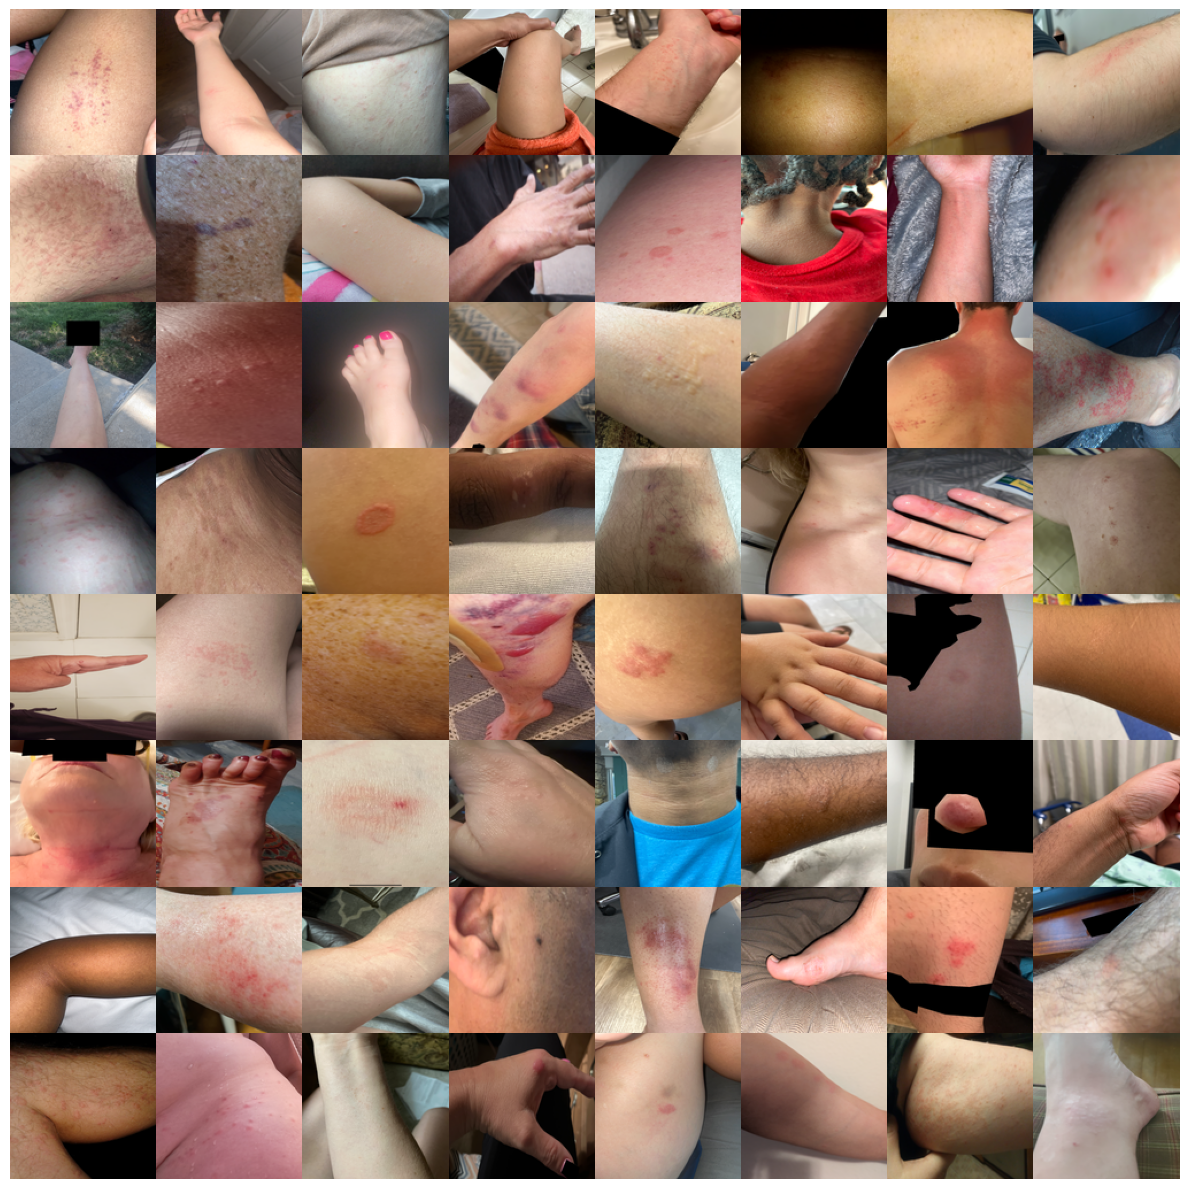

In [151]:
import matplotlib.pyplot as plt
from PIL import Image
import itertools

# 8x8 그리드 설정
rows, cols = 8, 8
thumb_size = (128, 128)

# LOOKS_HEALTHY 카테고리에서 idx가 짝수인 경로만 추출
healthy_paths = label_df[(label_df['related_category'] == "LOOKS_HEALTHY") & (label_df['dermatologist_gradable_for_skin_condition_1']=="NO_IMAGE_QUALITY_INSUFFICIENT")]['image_1_path']


# healthy_paths = data[(data['textures_fluid_filled'] == "YES")]['image_1_path'].iloc[::2]
# healthy_paths = data[data['related_category'] == 'LOOKS_HEALTHY']['image_1_path'].iloc[::2]

# 8x8 = 64장 선택
paths_for_grid = list(itertools.islice(healthy_paths, rows * cols))

# 서브플롯 생성
fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 1.5))

for ax, path in zip(axes.flat, paths_for_grid):
    filename = path.split('/')[-1]
    img = Image.open(f'./data/images_backup/{filename}').resize(thumb_size, Image.LANCZOS)
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout(w_pad=0, h_pad=0)
plt.show()

In [ ]:
# import shutil
# import os
# import pandas as pd

# # 레이블에 맞춰서 디렉토리 분리
# normal_images_path = './data/normal/normal_images'
# normal_df = pd.read_csv("./data/normal/normal.csv")

# normal_df = normal_df[normal_df['label']=='정상피부']['image_path']
# if os.path.exists("./data/normal/정상피부"):
#     shutil.rmtree("./data/normal/정상피부")
# os.makedirs("./data/normal/정상피부", exist_ok=True)


# for i in normal_df:
#     shutil.copy(f"./data/normal/정상피부/{i}", i)

In [158]:
data = pd.read_csv('./data/scin_labels.csv')
data

,case_id,dermatologist_gradable_for_skin_condition_1,dermatologist_gradable_for_skin_condition_2,dermatologist_gradable_for_skin_condition_3,dermatologist_skin_condition_on_label_name,dermatologist_skin_condition_confidence,weighted_skin_condition_label,dermatologist_gradable_for_fitzpatrick_skin_type_1,dermatologist_gradable_for_fitzpatrick_skin_type_2,dermatologist_gradable_for_fitzpatrick_skin_type_3,dermatologist_fitzpatrick_skin_type_label_1,dermatologist_fitzpatrick_skin_type_label_2,dermatologist_fitzpatrick_skin_type_label_3,gradable_for_monk_skin_tone_india,gradable_for_monk_skin_tone_us,monk_skin_tone_label_india,monk_skin_tone_label_us
0,-1000600354148496558,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,NaN,NaN,"['Inflicted skin lesions', 'Eczema', 'Irritant...","[4, 4, 3]","{'Inflicted skin lesions': 0.41, 'Eczema': 0.4...",YES,NaN,NaN,FST2,NaN,NaN,True,True,2.0,1.0
1,-1002039107727665188,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,NaN,NaN,"['Prurigo nodularis', 'Actinic Keratosis', 'SC...","[4, 3, 4]","{'Prurigo nodularis': 0.41, 'SCC/SCCIS': 0.41,...",YES,NaN,NaN,FST1,NaN,NaN,True,True,3.0,3.0
2,-1003358831658393077,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,NaN,NaN,"['Impetigo', 'Herpes Zoster', 'Bullous dermati...","[2, 1, 1]","{'Impetigo': 0.55, 'Herpes Zoster': 0.23, 'Bul...",YES,NaN,NaN,FST4,NaN,NaN,True,True,3.0,4.0
3,-1003826561155964328,NO_IMAGE_QUALITY_INSUFFICIENT,NaN,NaN,[],[],{},NO,NaN,NaN,NaN,NaN,NaN,True,True,2.0,4.0
4,-1003844406100696311,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,NaN,NaN,"['Lichen planus/lichenoid eruption', 'Follicul...","[1, 1, 1]","{'Lichen planus/lichenoid eruption': 0.33, 'Fo...",YES,NaN,NaN,FST1,NaN,NaN,True,True,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5028,973759811984683137,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,"['CD - Contact dermatitis', 'Allergic Contact ...","[5, 4, 5]","{'CD - Contact dermatitis': 0.33, 'Allergic Co...",YES,YES,YES,FST2,FST2,FST3,True,True,4.0,4.0
5029,973872028150293734,NO_IMAGE_QUALITY_INSUFFICIENT,NaN,NaN,[],[],{},NO,NaN,NaN,NaN,NaN,NaN,True,True,2.0,1.0
5030,983265958160210646,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,NaN,NaN,"['Impetigo', 'Foreign body']","[1, 1]","{'Impetigo': 0.5, 'Foreign body': 0.5}",YES,NaN,NaN,FST5,NaN,NaN,True,True,4.0,5.0
5031,995820220956352730,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,NaN,NaN,"['Erythema gyratum repens', 'Seborrheic Dermat...","[2, 2, 2]","{'Erythema gyratum repens': 0.33, 'Seborrheic ...",YES,NaN,NaN,FST4,NaN,NaN,True,True,3.0,2.0
